## Grokking hacking 8

In [7]:
import os
import sys
from functools import partial
from pathlib import Path

import transformer_lens
import einops
import numpy as np
import torch as t
import torch.nn.functional as F
from huggingface_hub import hf_hub_download
from jaxtyping import Float
from torch import Tensor
from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import to_numpy
import matplotlib.pyplot as plt

sys.path.append('/home/stephen/ARENA_3.0/chapter1_transformer_interp/exercises') #Point to some Arena helpers!
import part52_grokking_and_modular_arithmetic.utils as utils

In [4]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
t.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [5]:
p = 113

cfg = HookedTransformerConfig(
    n_layers=1,
    d_vocab=p + 1,
    d_model=128,
    d_mlp=4 * 128,
    n_heads=4,
    d_head=128 // 4,
    n_ctx=3,
    act_fn="relu",
    normalization_type=None,
    device=device,
)

model = HookedTransformer(cfg)

In [8]:
REPO_ID = "callummcdougall/grokking_full_run_data"
FILENAME = "full_run_data.pth"

local_dir = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

full_run_data = t.load(local_dir, weights_only=True)
state_dict = full_run_data["state_dicts"][400]

model = utils.load_in_state_dict(model, state_dict)

In [9]:
# Get all data and labels, and cache activations
all_data = t.tensor([(i, j, p) for i in range(p) for j in range(p)]).to(device)
labels = t.tensor([utils.target_fn(i, j) for i, j, _ in all_data]).to(device)
original_logits, cache = model.run_with_cache(all_data)

# Final position only, also remove the logits for `=`
original_logits = original_logits[:, -1, :-1]

# Get cross entropy loss
original_loss = utils.cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item():.3e}")

Original loss: 2.412e-07


In [10]:
# Helper variables
W_O = model.W_O[0]
W_K = model.W_K[0]
W_Q = model.W_Q[0]
W_V = model.W_V[0]
W_in = model.W_in[0]
W_out = model.W_out[0]
W_pos = model.W_pos
W_E = model.W_E[:-1]
final_pos_resid_initial = model.W_E[-1] + W_pos[2]
W_U = model.W_U[:, :-1]

#Functional Form
W_logit = W_out @ W_U

W_OV = W_V @ W_O
W_neur = W_E @ W_OV @ W_in

W_QK = W_Q @ W_K.transpose(-1, -2)
W_attn = final_pos_resid_initial @ W_QK @ W_E.T / (cfg.d_head**0.5)

In [12]:
m = all_data[:, 0]          # (N,)
n = all_data[:, 1]          # (N,)

t0 = F.one_hot(m, num_classes=p).float()   # (N, p)
t1 = F.one_hot(n, num_classes=p).float()   # (N, p)

# ----- 2. Compute alpha per head: α^h = σ(W_attn^h (t0 - t1)) -----
# diff: (N, p)
diff = t0 - t1

# W_attn: (n_heads, p)
# diff @ W_attn.T → (N, n_heads)
alpha = t.sigmoid(diff @ W_attn.T)         # (N, n_heads)

# For broadcasting later: (N, n_heads, 1)
alpha = alpha.unsqueeze(-1)

# ----- 3. Mix tokens per head: α^h t0 + (1-α^h) t1 -----
# Expand t0, t1 to (N, 1, p) to broadcast across heads
t0_exp = t0.unsqueeze(1)                   # (N, 1, p)
t1_exp = t1.unsqueeze(1)                   # (N, 1, p)

# token_mix: (N, n_heads, p)
token_mix = alpha * t0_exp + (1.0 - alpha) * t1_exp

# ----- 4. Map token_mix through W_neur -----
# W_neur: (n_heads, p, d_mlp)
# We want: (N, n_heads, d_mlp)
#
# Using einsum:
#  'nhp, hpd -> nhd'
neur_acts = t.einsum("nhp,hpd->nhd", token_mix, W_neur)  # (N, n_heads, d_mlp)

# Sum over heads: (N, d_mlp)
pre_mlp = neur_acts.sum(dim=1)

# ----- 5. ReLU, then logit projection -----
hidden = F.relu(pre_mlp)                  # (N, d_mlp)
logits = hidden @ W_logit                # (N, p)

In [13]:
for k in cache:
    print(k, cache[k].shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


Ok I'm certain that this will be somewhat iterative, let me start exporting various viz elements and thinking about how I want to viz along the way. The batch vs individual example is a bit tricky. Trying to figure out where I can put some kinda of stake in the ground. 

In [19]:
save_dir='/home/stephen/grokking/nov_24_1/'

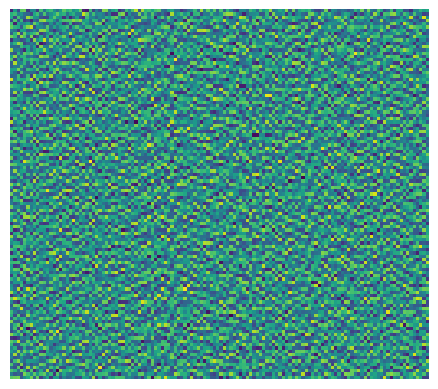

In [20]:
plt.imshow(W_E.detach().cpu().numpy()); plt.axis('off')
plt.savefig(save_dir+'W_E.png', dpi=150, transparent=True, bbox_inches='tight')

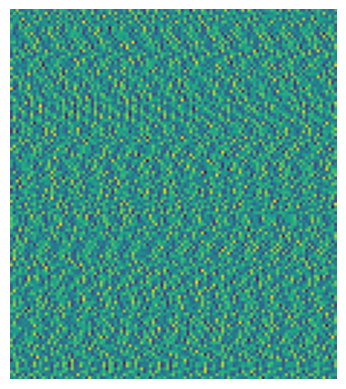

In [21]:
plt.imshow(W_U.detach().cpu().numpy()); plt.axis('off')
plt.savefig(save_dir+'W_U.png', dpi=150, transparent=True, bbox_inches='tight')

In [22]:
W_O.shape

torch.Size([4, 32, 128])

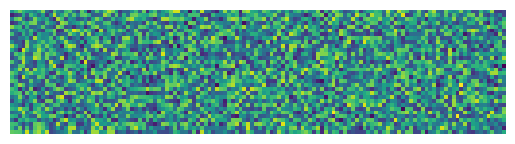

In [23]:
for head_id in range(4):
    plt.imshow(W_O[head_id].detach().cpu().numpy()); plt.axis('off')
    plt.savefig(save_dir+'W_O_'+str(head_id)+'.png', dpi=150, transparent=True, bbox_inches='tight')

In [24]:
W_K.shape

torch.Size([4, 128, 32])

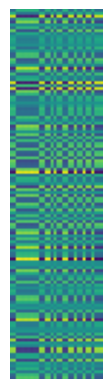

In [25]:
for head_id in range(4):
    plt.imshow(W_K[head_id].detach().cpu().numpy()); plt.axis('off')
    plt.savefig(save_dir+'W_K_'+str(head_id)+'.png', dpi=150, transparent=True, bbox_inches='tight')

In [ ]:
W_O = model.W_O[0]
W_K = model.W_K[0]
W_Q = model.W_Q[0]
W_V = model.W_V[0]
W_in = model.W_in[0]
W_out = model.W_out[0]
W_pos = model.W_pos